# Scrap Data from KCDC

## Import

In [369]:
%matplotlib inline

# for figure
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import pandas as pd
import numpy as np

import shutil
# importing os module
import os
# import datetime module
import datetime

import re

## Definitions

In [309]:
pd.options.display.max_rows = 100
# your path folder to save results
PATH_FOLDER_SAVE = '../../data'

PATH_CSV_DATA = PATH_FOLDER_SAVE + '/data.csv'

PATH_PAGES_KCDC_UPDATES = os.getcwd() + '/pages_kcdc_updates.json'

PATH_TABLES_KCDC_UPDATES = os.getcwd() + '/tables_kcdc_updates.json'

LIST_AREA = ["Seoul",
"Busan",
"Daegu",
"Incheon",
"Gwangju",
"Daejeon",
"Ulsan",
"Sejong",
"Gyeonggi",
"Gangwon",
"Chungbuk",
"Chungnam",
"Cheonbuk",
"Cheonnam",
"Gyeongbuk",
"Gyeongnam",
"Jeju"]

LIST_STR_TO_FIND = ["COVID",
                    "Coronavirus",
                    "coronavirus",
                   "additional cases"]

## Helper functions

In [29]:
# save before scraping
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))


In [13]:
import scrapy
import scrapy.crawler as crawler
from multiprocessing import Process, Queue
from twisted.internet import reactor

# the wrapper to make it run more times
def run_spider(spider):
    '''
    DOESNT WORK WITH LAST VERSION OF SCRAPY OR TWISTED ??? 
    BUG
    function to run several times scraping process
    '''
    def f(q):
        try:
            runner = crawler.CrawlerRunner()
            deferred = runner.crawl(spider)
            deferred.addBoth(lambda _: reactor.stop())
            reactor.run()
            q.put(None)
        except Exception as e:
            q.put(e)

    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    result = q.get()
    p.join()

    if result is not None:
        raise result


## Scrap pages links

In [310]:
%%writefile kcdcspider.py
# -*-coding:utf-8 -*

#
# Class to scrap KCDC Tables values for each town/area in South Korea
#

#import
import re
import scrapy

# definitions
URL_ROOT = 'https://www.cdc.go.kr'
NUM_MAX_PAGES = 8
PATH_OUTPUT = 'pages_kcdc_updates.json'
URL_FIRST_PAGE = URL_ROOT + '/board.es?mid=a30402000000&bid=0030&nPage=1'

LIST_STR_TO_FIND = ["COVID",
                    "Coronavirus",
                    "coronavirus",
                   "additional cases"]

# Spider Class
class KCDCPageSpider(scrapy.Spider):
    '''
    Spider to scrap all Le Gorafi pages from selected category
    Configure : 
    - KCDCPageSpider.custom_settings : save location 
    - num_max_pages : the number of next page to scrap
    - url_first_page : web page to start with
    '''
    name = "kcdc_updates_page"
    
    custom_settings = {
      'FEED_FORMAT': 'json',
      'FEED_URI': PATH_OUTPUT
    }
    
    num_max_pages = NUM_MAX_PAGES
    
    url_first_page = URL_FIRST_PAGE
    
    def start_requests(self):
        urls = [
                self.url_first_page,
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
    
    def parse(self, response):
        str_pattern = '//div[@class="dbody"]/ul/li/a[contains(@title,"{}")]'
        str_search = ''
        for str_curr in LIST_STR_TO_FIND:
            str_search = str_search + str_pattern.format(str_curr) + '|'
        str_search = str_search[0:-1]
        #'//div[@class="dbody"]/ul/li/a[contains(@title,"updates")]|' + \
        #    '//div[@class="dbody"]/ul/li/a[contains(@title,"Updates")]'
        for post in response.xpath(str_search):
            yield {
                'link': URL_ROOT + post.xpath('@href').extract_first()
            }
        # https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=2
        #//a[@class="pageNext"]/@href
        next_page = response.xpath('//a[@class="pageNext"]/@href').get()
        
        if next_page is not None:
            try:
                num_next_page = int(re.search("(?<=\&nPage\=)\d+$", 
                         next_page).group(0))
                
                if (num_next_page < self.num_max_pages):
                    #next_page = response.urljoin(next_page)
                    next_page = URL_ROOT + next_page
                    yield scrapy.Request(next_page, callback=self.parse)
            except:
                next_page = None

Overwriting kcdcspider.py


In [311]:
%%writefile run_kcdc_pages_updates.py
# -*-coding:utf-8 -*

#
# Run scrapy for retrieve updates pages links from KCDC
#

# import
import scrapy
from scrapy.crawler import CrawlerProcess
from kcdcspider import KCDCPageSpider

process = CrawlerProcess()

process.crawl(KCDCPageSpider)
process.start() # the script will block here until the crawling is finished

Overwriting run_kcdc_pages_updates.py


In [454]:
%%time
try:
    # clean (move file if exist)
    clean_file(PATH_PAGES_KCDC_UPDATES)
    # execute external process (FALLBACK for scrapy problem)
    !python run_kcdc_pages_updates.py 
except:
    print("Error run_kcdc_pages_updates !")

File /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/pages_kcdc_updates_20200301_15_54_20.json moved!
2020-03-01 15:54:20 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: scrapybot)
2020-03-01 15:54:20 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.9, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.10.0, Python 3.7.6 (default, Jan  8 2020, 13:42:34) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Darwin-18.7.0-x86_64-i386-64bit
2020-03-01 15:54:20 [scrapy.crawler] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'pages_kcdc_updates.json'}
2020-03-01 15:54:20 [scrapy.extensions.telnet] INFO: Telnet Password: e0d660e9e24e67b4
2020-03-01 15:54:21 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extens

2020-03-01 15:54:22 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=4> (referer: https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=3)
2020-03-01 15:54:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=4>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366255&tag=&nPage=4'}
2020-03-01 15:54:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=4>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366249&tag=&nPage=4'}
2020-03-01 15:54:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=4>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366247&tag=&nPage=4'}
2020-03-01 15:54:22 [scrapy.core.scraper] DEBUG: Scraped

CPU times: user 94.2 ms, sys: 38.1 ms, total: 132 ms
Wall time: 3.6 s


In [455]:
df_pages_kcdc_updates = pd.read_json(PATH_PAGES_KCDC_UPDATES)
print("Nb news : ", df_pages_kcdc_updates.shape[0])
df_pages_kcdc_updates

Nb news :  63


,link
0,https://www.cdc.go.kr/board/board.es?mid=a3040...
1,https://www.cdc.go.kr/board/board.es?mid=a3040...
2,https://www.cdc.go.kr/board/board.es?mid=a3040...
3,https://www.cdc.go.kr/board/board.es?mid=a3040...
4,https://www.cdc.go.kr/board/board.es?mid=a3040...
5,https://www.cdc.go.kr/board/board.es?mid=a3040...
6,https://www.cdc.go.kr/board/board.es?mid=a3040...
7,https://www.cdc.go.kr/board/board.es?mid=a3040...
8,https://www.cdc.go.kr/board/board.es?mid=a3040...
9,https://www.cdc.go.kr/board/board.es?mid=a3040...


In [297]:
# TODO ?
'''# configure scraping
KCDCPageSpider.url_first_page = URL_PAGES_KCDC_UPDATES
KCDCPageSpider.custom_settings = {
      'FEED_FORMAT': 'json',
      'FEED_URI': URL_PAGES_KCDC_UPDATES
    }
KCDCPageSpider.num_max_pages = 1

# clean last output
clean_file(PATH_PAGES_KCDC_UPDATES)
# scraping page urls 
run_spider(KCDCPageSpider)'''
# DOES NOT WORK ANYMORE !


"# configure scraping\nKCDCPageSpider.url_first_page = URL_PAGES_KCDC_UPDATES\nKCDCPageSpider.custom_settings = {\n      'FEED_FORMAT': 'json',\n      'FEED_URI': URL_PAGES_KCDC_UPDATES\n    }\nKCDCPageSpider.num_max_pages = 1\n\n# clean last output\nclean_file(PATH_PAGES_KCDC_UPDATES)\n# scraping page urls \nrun_spider(KCDCPageSpider)"

## Scrap updates tables

In [329]:
%%writefile kcdctablespider.py
# -*-coding:utf-8 -*

#
# Module for scrapy over tables in KCDC
#

# import
import re
import scrapy
from scrapy.loader import ItemLoader
from scrapy.loader.processors import MapCompose, Join, TakeFirst
from w3lib.html import remove_tags


# definitions 
URL_ROOT = 'https://www.cdc.go.kr'
PATH_TABLES_OUTPUT = 'tables_kcdc_updates.json'
URL_FIRST_PAGE = URL_ROOT + '/board.es?mid=a30402000000&bid=0030&nPage=1'

LIST_AREA = ["Seoul",
"Busan",
"Daegu",
"Incheon",
"Gwangju",
"Daejeon",
"Ulsan",
"Sejong",
"Gyeonggi",
"Gangwon",
"Chungbuk",
"Chungnam",
"Cheonbuk",
"Cheonnam",
"Gyeongbuk",
"Gyeongnam",
"Jeju"]

def convert_int(str_in):
    # suppress ","
    str_in = re.sub(',', '', str_in)
    # convert in integer
    return int(str_in)

def find_in_table(response, n_row, n_col):
    search_str = '//tbody/tr/td/p/' + \
        'span[contains(., "Confirmed")]' + \
        '/../../../..//tr[{}]/td[{}]'.format(n_row, n_col) + \
        '/p/span[re:test(.,"^\d")]//text()'

    text_found = response.xpath(search_str).get()
    return text_found 




def find_int_in_table(response, n_row, n_col):
    text_found = find_in_table(response, n_row, n_col)
    if isinstance(text_found, str):
        return convert_int(text_found)
    else:
        return text_found


def find_int_area_in_table(response, area):
    
    flag_add = None
    
    search_str = '//tbody/tr[1]/td[1][contains(., "Regions")]/../../' + \
        'tr/td/p/span[contains(., "{}")]'.format(area) + \
        '/../../../td[2]/p/span[re:test(.,"^\d")]//text()'
    text_found = response.xpath(search_str).get()
    
    # if old style table (area in columns)
    if text_found is None:
        # search # of columns
        
        text_col = ''
        I_col_area = 1
        while text_col != None:
            search_str = '//tbody/tr[1]/td[1][contains(., "Place")]' + \
                '/../../tr[2]/td[{}]/p/span/text()'.format(I_col_area)
            text_col = response.xpath(search_str).get()
            if text_col == area:
                break
            I_col_area = I_col_area + 1
        
        search_str = '//tbody/tr[1]/td[1][contains(., "Place")]/../../' + \
            'tr/td/p/span[contains(., "{}")]'.format(area) + \
            '/../../../../tr[3]/td[{}]'.format(I_col_area + 1) + \
            '/p/span[re:test(.,"^\d")]//text()'  
        
        text_found = response.xpath(search_str).get()
        if text_found is not None:
            flag_add = True
    else:
        flag_add = False
        
    if isinstance(text_found, str):
        return flag_add, convert_int(text_found)
    else:
        return flag_add, text_found
    

class KCDCiItem(scrapy.Item):
    '''
    Class item to declare different information to scrap
    and how to process (as input or output)
    '''
    # define the fields for your item here like:
    url = scrapy.Field(output_processor=TakeFirst())
    
    source = scrapy.Field(output_processor=TakeFirst())
    
    date_published = scrapy.Field(
        input_processor=MapCompose(remove_tags),
        output_processor=TakeFirst()
    )
    
    total = scrapy.Field(output_processor=TakeFirst())
    
    flag_add = scrapy.Field(output_processor=TakeFirst())
    
    Seoul = scrapy.Field(output_processor=TakeFirst())   

    Busan = scrapy.Field(output_processor=TakeFirst())  
    Daegu = scrapy.Field(output_processor=TakeFirst())  
    Incheon = scrapy.Field(output_processor=TakeFirst())  
    Gwangju = scrapy.Field(output_processor=TakeFirst())  
    Daejeon = scrapy.Field(output_processor=TakeFirst())  
    Ulsan = scrapy.Field(output_processor=TakeFirst())  
    Sejong = scrapy.Field(output_processor=TakeFirst())  
    Gyeonggi = scrapy.Field(output_processor=TakeFirst())  
    Gangwon = scrapy.Field(output_processor=TakeFirst())  
    Chungbuk = scrapy.Field(output_processor=TakeFirst())  
    Chungnam = scrapy.Field(output_processor=TakeFirst())  
    Cheonbuk = scrapy.Field(output_processor=TakeFirst())  
    Cheonnam = scrapy.Field(output_processor=TakeFirst())  
    Gyeongbuk = scrapy.Field(output_processor=TakeFirst())  
    Gyeongnam = scrapy.Field(output_processor=TakeFirst())  
    Jeju = scrapy.Field(output_processor=TakeFirst())  
    

class KCDCTablesSpider(scrapy.Spider):
    '''
    Spider to scrap tables webpages : 
    - how to find information for scraping
    - which field names to store
    '''
    # Your spider definition
    name = 'tables_kcdc_spider'
    # output definition :
    custom_settings = {
      'FEED_FORMAT': 'json',
      'FEED_URI': PATH_TABLES_OUTPUT
  }
    # urls to scrap
    start_urls = [URL_FIRST_PAGE]
   
    def parse(self, response):
        '''
        Parse definition with xpath which define all patterns to use
        for retrieve information into HTML strings
        '''
        #url	source	author	title	theme	description	date_published	body   
        l = ItemLoader(item=KCDCiItem(), selector=response)
        
        l.add_value('url', response.url)
        
        l.add_value('source', "KCDC")
        
        # '//span[re:test(.,"^Update$")]/../b//text()', 
        l.add_xpath("date_published", 
            '//ul[@class="head info"]/li/span[contains(.,"Date")]/../b//text()',
                    re="[0-9]+-[0-9]+-[0-9]+")
        
        # check if more than 1 row of data
        flag_total = find_in_table(response, 4, 3)
        
        if flag_total is not None: # take 3rd row           
            
            flag_sub = response.xpath('//tbody/tr/td/p/' + \
                'span[contains(., "Confirmed")]/../../../..//tr[2]/td[1]' + \
                '/p/span[re:test(.,"^Sub")]//text()').get()
            
            # if sub total exist (don't sum up)
            if flag_sub is not None:
                int_total_2 = find_int_in_table(response, 3, 3)
                int_total_3 = find_int_in_table(response, 4, 3)
            
            else:
                int_2_1 = find_int_in_table(response, 3, 3)
                int_2_2 = find_int_in_table(response, 3, 4)
                int_total_2 = int_2_1 + int_2_2
                int_3_1 = find_int_in_table(response, 4, 3)
                int_3_2 = find_int_in_table(response, 4, 4)
                int_total_3 = int_3_1 + int_3_2
            
            if int_total_3 > int_total_2:
                l.add_value("total", int_total_3)
            else:
                l.add_value("total", int_total_2)
            
        else: # take 2nd row
            int_total = find_int_in_table(response, 3, 3)
            l.add_value("total", int_total)
            
        flag_add = False
        
        for area in LIST_AREA:
            
            flag_add_curr, int_area = find_int_area_in_table(response, area)
            
            if flag_add_curr == True:
                flag_add = True
                
            if int_area is not None:
                l.add_value(area, int_area)
                
        l.add_value("flag_add", flag_add)
                
        yield l.load_item()


Overwriting kcdctablespider.py


In [330]:
%%writefile run_kcdc_tables_updates.py
# -*-coding:utf-8 -*

#
# Run scrapy for retrieve updates tables from KCDC
#

# import
import scrapy
from scrapy.crawler import CrawlerProcess
from kcdctablespider import KCDCTablesSpider
import pandas as pd
import os

# definitions
PATH_PAGES_KCDC_UPDATES = os.getcwd() + '/pages_kcdc_updates.json'

# get urls pages links
df_pages_kcdc_updates = pd.read_json(PATH_PAGES_KCDC_UPDATES)
# define url for scrapy
KCDCTablesSpider.start_urls = df_pages_kcdc_updates["link"].tolist()

# start scraping process
process = CrawlerProcess()
process.crawl(KCDCTablesSpider)
process.start() # the script will block here until the crawling is finished

Overwriting run_kcdc_tables_updates.py


In [456]:
%%time
try:
    # clean (move file if exist)
    clean_file(PATH_TABLES_KCDC_UPDATES)
    # execute external process (FALLBACK for scrapy problem)
    !python run_kcdc_tables_updates.py 
except:
    print("Error run_kcdc_tables_updates !")

File /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/tables_kcdc_updates_20200301_15_54_46.json moved!
2020-03-01 15:54:48 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: scrapybot)
2020-03-01 15:54:48 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.9, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.10.0, Python 3.7.6 (default, Jan  8 2020, 13:42:34) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Darwin-18.7.0-x86_64-i386-64bit
2020-03-01 15:54:48 [scrapy.crawler] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'tables_kcdc_updates.json'}
2020-03-01 15:54:48 [scrapy.extensions.telnet] INFO: Telnet Password: 3bf161914a615734
2020-03-01 15:54:48 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.exte

2020-03-01 15:54:49 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366350&tag=&nPage=2> (referer: None)
2020-03-01 15:54:49 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366357&tag=&nPage=1>
{'date_published': '2020-02-27',
 'flag_add': False,
 'source': 'KCDC',
 'total': 1595,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366357&tag=&nPage=1'}
2020-03-01 15:54:49 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366363&tag=&nPage=1>
{'Busan': 58,
 'Cheonbuk': 3,
 'Cheonnam': 1,
 'Chungbuk': 7,
 'Chungnam': 7,
 'Daegu': 1017,
 'Daejeon': 8,
 'Gangwon': 6,
 'Gwangju': 9,
 'Gyeongbuk': 321,
 'Gyeonggi': 55,
 'Gyeongnam': 36,
 'Incheon': 3,
 'Jeju': 2,
 'Sejong': 1,
 'Seoul': 55,
 'Ulsan': 6,
 'date_published': '

2020-03-01 15:54:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366301&tag=&nPage=3>
{'Busan': 1,
 'Daegu': 55,
 'Daejeon': 1,
 'Gyeonggi': 4,
 'Seoul': 3,
 'Ulsan': 1,
 'date_published': '2020-02-22',
 'flag_add': True,
 'source': 'KCDC',
 'total': 433,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366301&tag=&nPage=3'}
2020-03-01 15:54:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366299&tag=&nPage=3>
{'date_published': '2020-02-22',
 'flag_add': False,
 'source': 'KCDC',
 'total': 346,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366299&tag=&nPage=3'}
2020-03-01 15:54:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366264&tag=&nPage=3>
{'date_published'

2020-03-01 15:54:51 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366165&tag=&nPage=5> (referer: None)
2020-03-01 15:54:51 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366157&tag=&nPage=5> (referer: None)
2020-03-01 15:54:51 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366162&tag=&nPage=5> (referer: None)
2020-03-01 15:54:51 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366193&tag=&nPage=5>
{'date_published': '2020-02-14',
 'flag_add': False,
 'source': 'KCDC',
 'total': 28,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366193&tag=&nPage=5'}
2020-03-01 15:54:51 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.

2020-03-01 15:54:51 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366142&tag=&nPage=5>
{'date_published': '2020-02-10',
 'flag_add': False,
 'source': 'KCDC',
 'total': 24,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366142&tag=&nPage=5'}
2020-03-01 15:54:51 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366138&tag=&nPage=6>
{'date_published': '2020-02-10',
 'flag_add': False,
 'source': 'KCDC',
 'total': 27,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366138&tag=&nPage=6'}
2020-03-01 15:54:52 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366003&tag=&nPage=7> (referer: None)
2020-03-01 15:54:52 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.

In [457]:
PATH_TABLES_KCDC_UPDATES

'/Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/tables_kcdc_updates.json'

In [458]:
df_tables_kcdc_updates = pd.read_json(PATH_TABLES_KCDC_UPDATES)
df_tables_kcdc_updates = df_tables_kcdc_updates.sort_values(by=['date_published'])
print("Nb. coronavirus articles : ", df_tables_kcdc_updates.shape[0])
df_tables_kcdc_updates

Nb. coronavirus articles :  62


,url,source,date_published,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Cheonbuk,Cheonnam,Gyeongbuk,Gyeongnam,Jeju
60,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-31,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-01,12.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-02,15.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-04,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-04,16.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-05,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-05,18.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-05,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-06,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-06,23.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### clean dates


#### Keep only row with at least one non-Nan value in Total or Areas

In [459]:
list_col = LIST_AREA.copy()
list_col.append("total")
df_tables_kcdc_updates.dropna(how='all', inplace=True, subset=list_col)
print("Nb articles : ", df_tables_kcdc_updates.shape[0])
df_tables_kcdc_updates

Nb articles :  57


,url,source,date_published,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Cheonbuk,Cheonnam,Gyeongbuk,Gyeongnam,Jeju
59,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-01,12.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-02,15.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-04,16.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-05,18.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-06,23.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-07,24.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-07,24.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-08,24.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-08,22.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-09,25.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Total value 
- Total = max(Total per day)
- Area Value for each = keep non-additive result max(Area per day)

In [461]:
df_kcdc = df_tables_kcdc_updates.copy()
df_kcdc = df_kcdc[df_kcdc["flag_add"] == False].groupby("date_published").max()
df_kcdc

,url,source,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,Daejeon,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Cheonbuk,Cheonnam,Gyeongbuk,Gyeongnam,Jeju
date_published,,,,,,,,,,,,,,,,,,,,,
2020-02-01,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,12.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,15.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,18.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-06,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,23.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-07,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-09,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,25.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-10,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,27.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Area value

- if only additive : try to extrapolate from day after

In [463]:
# loop over days from most recent to oldest
def correct_addtive_value(df_in):
    list_day = df_in.index
    df_kcdc = df_in.copy()
    for I_day in range(len(list_day)-1, -1, -1):
        day_curr = list_day[I_day]
        #print(day_curr)
        #print(df_kcdc.at[day_curr, "Seoul"])
        if pd.isna(df_kcdc.at[day_curr, "Seoul"]) & (I_day+1 < len(list_day)):
            print("Correction needed for day : ", day_curr)
            day_curr_after = list_day[I_day+1]
            #print("after : " , day_curr_after)
            df_after = df_tables_kcdc_updates[\
                (df_tables_kcdc_updates["date_published"] == day_curr_after) & \
                (df_tables_kcdc_updates["flag_add"] == True)]
            #print(df_after.max())
            if df_after.shape[0] > 0:
                print("Correction OK for day : ", day_curr)
                df_after = df_after.max()
               # print(df_after.loc[LIST_AREA])
               # print(df_after.shape)
                df_kcdc.loc[day_curr, LIST_AREA] = \
                    df_kcdc.loc[day_curr_after, LIST_AREA] - \
                    df_after.loc[LIST_AREA]
            else:
                print("Correction NOK ! for day : ", day_curr)
    return df_kcdc


df_kcdc_corr = correct_addtive_value(df_kcdc)   
df_kcdc_corr

Correction needed for day :  2020-02-23
Correction OK for day :  2020-02-23
Correction needed for day :  2020-02-22
Correction OK for day :  2020-02-22
Correction needed for day :  2020-02-20
Correction OK for day :  2020-02-20
Correction needed for day :  2020-02-19
Correction NOK ! for day :  2020-02-19
Correction needed for day :  2020-02-18
Correction NOK ! for day :  2020-02-18
Correction needed for day :  2020-02-17
Correction NOK ! for day :  2020-02-17
Correction needed for day :  2020-02-16
Correction NOK ! for day :  2020-02-16
Correction needed for day :  2020-02-15
Correction NOK ! for day :  2020-02-15
Correction needed for day :  2020-02-14
Correction NOK ! for day :  2020-02-14
Correction needed for day :  2020-02-13
Correction NOK ! for day :  2020-02-13
Correction needed for day :  2020-02-12
Correction NOK ! for day :  2020-02-12
Correction needed for day :  2020-02-11
Correction NOK ! for day :  2020-02-11
Correction needed for day :  2020-02-10
Correction NOK ! for 

,url,source,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,Daejeon,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Cheonbuk,Cheonnam,Gyeongbuk,Gyeongnam,Jeju
date_published,,,,,,,,,,,,,,,,,,,,,
2020-02-01,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,12.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,15.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,18.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-06,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,23.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-07,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-09,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,25.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-10,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,27.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Correction time continuity

if no row for a day, add a row by linear interpolation needed

In [464]:
df_kcdc_corr.index[0]

'2020-02-01'

In [465]:
df_kcdc_corr.index[-1]

'2020-03-01'

In [466]:
 range_days = pd.date_range(start=df_kcdc_corr.index[0], 
                            end=df_kcdc_corr.index[-1])

In [467]:
df_kcdc_corr.index = df_kcdc_corr.index.astype('datetime64[ns]')

In [468]:
df_kcdc_corr = df_kcdc_corr.reindex(range_days)
df_kcdc_corr

,url,source,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,Daejeon,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Cheonbuk,Cheonnam,Gyeongbuk,Gyeongnam,Jeju
2020-02-01,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,12.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,15.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,18.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-06,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,23.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-07,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-09,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,25.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-10,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,27.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [469]:
# interpolation between before - after days : 
# loop over days
def correct_interpol_value(df_in):
    list_day = df_in.index
    df_kcdc = df_in.copy()
    for I_day in range(1, len(list_day)-1):
        day_curr = list_day[I_day]
        #print(day_curr)
        #print(df_kcdc.at[day_curr, "Seoul"])
        if pd.isna(df_kcdc.at[day_curr, "total"]):
            print("Correction needed for day : ", day_curr)
            day_curr_before = list_day[I_day-1]
            day_curr_after = list_day[I_day+1]
            
            # Value day curr = mean(value before & after)
            df_kcdc.loc[day_curr, list_col] = \
                (0.5*df_kcdc.loc[day_curr_before, list_col] + \
                0.5*df_kcdc.loc[day_curr_after, list_col]).astype(np.int64, 
                                                             errors='ignore')
    return df_kcdc


df_kcdc_interp = correct_interpol_value(df_kcdc_corr)   
df_kcdc_interp

Correction needed for day :  2020-02-03 00:00:00
Correction needed for day :  2020-02-21 00:00:00


,url,source,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,Daejeon,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Cheonbuk,Cheonnam,Gyeongbuk,Gyeongnam,Jeju
2020-02-01,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,12.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,15.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,NaN,NaN,15.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,18.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-06,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,23.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-07,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-09,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,25.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-10,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,27.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Figures

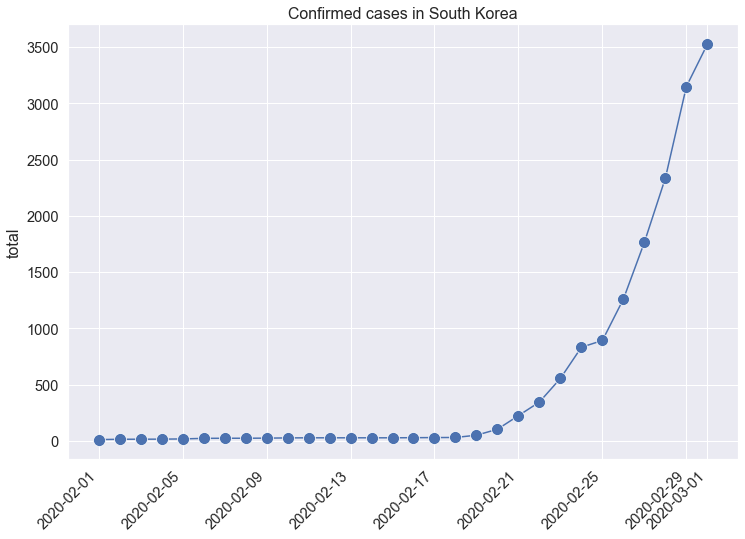

In [470]:
fig = plt.figure(figsize=(12, 8))

g = sns.lineplot(x=df_kcdc_interp.index, y="total", data=df_kcdc_interp, 
             markersize=12, marker="o");
plt.title("Confirmed cases in South Korea");
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
);

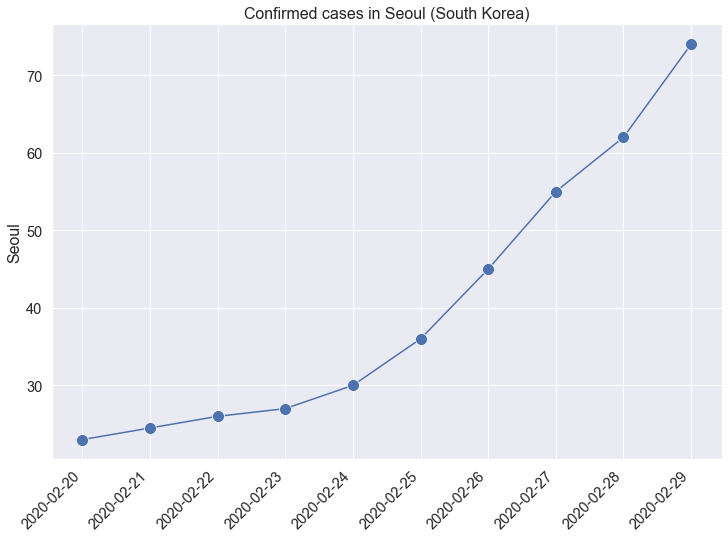

In [471]:
fig = plt.figure(figsize=(12, 8))

g = sns.lineplot(x=df_kcdc_interp.index, y="Seoul", data=df_kcdc_interp, 
             markersize=12, marker="o");
plt.title("Confirmed cases in Seoul (South Korea)");
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
);

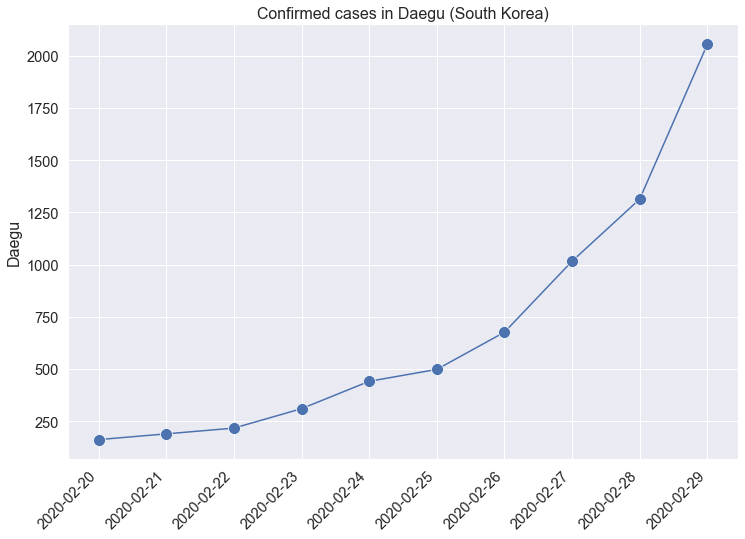

In [448]:
fig = plt.figure(figsize=(12, 8))

g = sns.lineplot(x=df_kcdc_interp.index, y="Daegu", data=df_kcdc_interp, 
             markersize=12, marker="o");
plt.title("Confirmed cases in Daegu (South Korea)");
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
);

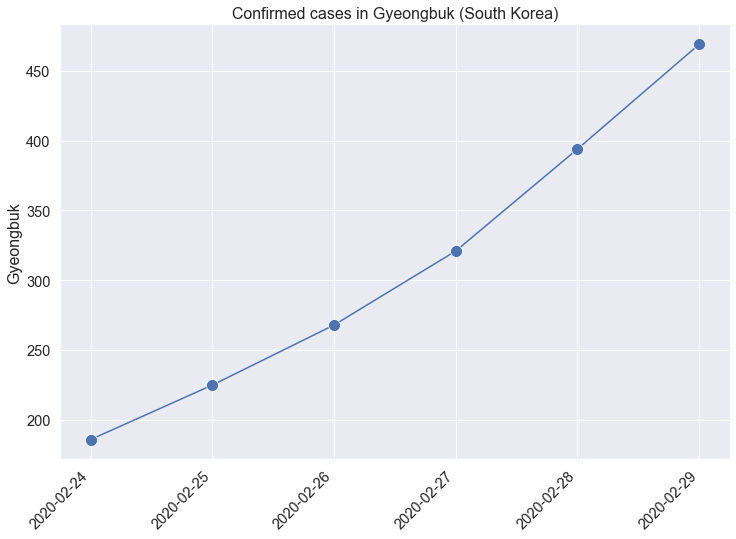

In [450]:

fig = plt.figure(figsize=(12, 8))

g = sns.lineplot(x=df_kcdc_interp.index, y="Gyeongbuk", data=df_kcdc_interp, 
             markersize=12, marker="o");
plt.title("Confirmed cases in Gyeongbuk (South Korea)");
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
);

In [518]:
df_kcdc_interp["date"] = df_kcdc_interp.index
df_kcdc_interp["country"] = 'Korea, Rep.'
df_kcdc_interp["iso_alpha"] = 'KOR'


In [513]:
df_kcdc_interp["day"] = range(1, df_kcdc_interp.shape[0]+1)

In [524]:
import plotly.express as px

fig = px.scatter_geo(df_kcdc_interp, locations="iso_alpha", color="country",
                     hover_name="country", size="total", animation_frame="day",
                     projection="natural earth")
fig.update_geos(fitbounds="locations")
fig.show()

In [516]:
import plotly.express as px
df = px.data.gapminder()
fig = px.scatter_geo(df, locations="iso_alpha", color="continent",
                     hover_name="country", size="pop",
                     animation_frame="year",
                     projection="natural earth")
fig.show()


In [517]:
df[df["country"] == 'Korea, Rep.']

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
840,"Korea, Rep.",Asia,1952,47.453,20947571,1030.592226,KOR,410
841,"Korea, Rep.",Asia,1957,52.681,22611552,1487.593537,KOR,410
842,"Korea, Rep.",Asia,1962,55.292,26420307,1536.344387,KOR,410
843,"Korea, Rep.",Asia,1967,57.716,30131000,2029.228142,KOR,410
844,"Korea, Rep.",Asia,1972,62.612,33505000,3030.876650,KOR,410
845,"Korea, Rep.",Asia,1977,64.766,36436000,4657.221020,KOR,410
846,"Korea, Rep.",Asia,1982,67.123,39326000,5622.942464,KOR,410
847,"Korea, Rep.",Asia,1987,69.810,41622000,8533.088805,KOR,410
848,"Korea, Rep.",Asia,1992,72.244,43805450,12104.278720,KOR,410
849,"Korea, Rep.",Asia,1997,74.647,46173816,15993.527960,KOR,410


In [503]:
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_ebola.csv')
df.head()

colors = ['rgb(239,243,255)','rgb(189,215,231)','rgb(107,174,214)','rgb(33,113,181)']
months = {6:'June',7:'July',8:'Aug',9:'Sept'}

fig = go.Figure()

for i in range(6,10)[::-1]:
    df_month = df.query('Month == %d' %i)
    fig.add_trace(go.Scattergeo(
            lon = df_month['Lon'],
            lat = df_month['Lat'],
            text = df_month['Value'],
            name = months[i],
            marker = dict(
                size = df_month['Value']/50,
                color = colors[i-6],
                line_width = 0
            )))


fig.update_layout(
    title = go.layout.Title(
        text = 'Ebola cases reported by month in West Africa 2014<br> \
Source: <a href="https://data.hdx.rwlabs.org/dataset/rowca-ebola-cases">\
HDX</a>'),
    geo = go.layout.Geo(
        resolution = 50,
        scope = 'africa',
        showframe = False,
        showcoastlines = True,
        landcolor = "rgb(229, 229, 229)",
        countrycolor = "white" ,
        coastlinecolor = "white",
        projection_type = 'mercator',
        lonaxis_range= [ -15.0, -5.0 ],
        lataxis_range= [ 0.0, 12.0 ],
        domain = dict(x = [ 0, 1 ], y = [ 0, 1 ])
    ),
    geo2 = go.layout.Geo(
        scope = 'africa',
        showframe = False,
        landcolor = "rgb(229, 229, 229)",
        showcountries = False,
        domain = dict(x = [ 0, 0.6 ], y = [ 0, 0.6 ]),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    ),
    legend_traceorder = 'reversed'
)
fig.show()